In [2]:
import numpy as np
from keras.datasets import mnist
from PIL import Image
import matplotlib.pyplot as plt

#### CNN Layer

In [3]:
class CNNLayer:
    def __init__(self, kernel_size, number_of_kernels, input_shape):
        assert len(input_shape) == 3, "Input shape must be 3D" 
        self.input_channels = input_shape[2]
        
        self.input_shape = input_shape
        self.kernel_size = kernel_size
        self.number_of_kernels = number_of_kernels
        self.kernels = np.random.randn(kernel_size, kernel_size, self.input_channels, number_of_kernels)
        
        # output shape
        self.output_shape = (input_shape[0] - kernel_size + 1, input_shape[1] - kernel_size + 1, number_of_kernels)
        self.biases = np.random.randn(*self.output_shape)
        
        self.input = None
        self.output = None
    
    def forward(self, input):
        assert input.shape == self.input_shape, "Input shape is not correct. " + "Expected: " + str(self.input_shape) + " Actual: " + str(input.shape)

        self.input = input
        output = np.zeros(self.output_shape)
        for i in range(self.number_of_kernels):
            for j in range(self.input_channels):
                imageChannel = input[:, :, j]
                filter = self.kernels[:, :, j, i]
                result = np.zeros((imageChannel.shape[0] - filter.shape[0] + 1, imageChannel.shape[1] - filter.shape[1] + 1))
                for x in range(result.shape[0]):
                    for y in range(result.shape[1]):
                        result[x, y] = np.sum(imageChannel[x:x+filter.shape[0], y:y+filter.shape[1]] * filter)
                output[:, :, i] += result
        
        output += self.biases
        
        self.output = output
        return output
    
    def backward(self, gradWRTMyOutput, learning_rate):
        assert gradWRTMyOutput.shape == self.output_shape, "Grad shape is not correct at CNN layer with kernel size: " + str(self.kernel_size) + " Expected: " + str(self.output_shape) + " Actual: " + str(gradWRTMyOutput.shape)
        
        input = self.input
        # Compute gradient with respect to kernels
        kernel_grads = np.zeros(self.kernels.shape)
        for i in range(self.number_of_kernels):
            for j in range(self.input_channels):
                channel = input[:, :, j]
                kernel = gradWRTMyOutput[:, :, i]
                result = np.zeros((channel.shape[0] - kernel.shape[0] + 1, channel.shape[1] - kernel.shape[1] + 1))
                for x in range(result.shape[0]):
                    for y in range(result.shape[1]):
                        result[x, y] = np.sum(channel[x:x+kernel.shape[0], y:y+kernel.shape[1]] * kernel)
                kernel_grads[:, :, j, i] = result

        # Compute gradient with respect to biases
        bias_grads = gradWRTMyOutput.copy()
        
        # Compute gradient with respect to input
        input_grads = np.zeros(input.shape)
        for j in range(self.input_channels):
            for i in range(self.number_of_kernels):
                channel = gradWRTMyOutput[:, :, i]
                kernel = self.kernels[:, :, j, i]
                kernel = np.flip(kernel)
                result = np.zeros((channel.shape[0] + kernel.shape[0] - 1, channel.shape[1] + kernel.shape[1] - 1))
                for x in range(result.shape[0]):
                    for y in range(result.shape[1]):
                        for k in range(kernel.shape[0]):
                            for l in range(kernel.shape[1]):
                                if x - k >= 0 and x - k < channel.shape[0] and y - l >= 0 and y - l < channel.shape[1]:
                                    result[x, y] += channel[x - k, y - l] * kernel[k, l]
                
                input_grads[:, :, j] += result                
        
        # Update kernels and biases
        self.kernels -= learning_rate * kernel_grads
        self.biases -= learning_rate * bias_grads
        
        return input_grads

#### Sigmoid Layer
Input: (x, y, z) where z is the number of channels

Output: (x', y', z')

Error_Grad_WRT_Input: Error_Grad_WRT_Output * Output_Grad_WRT_Input , where * is element-wise multiplication

In [4]:
class SigmoidLayer:
    def __init__(self, input_shape):
        # Input shape is 3D
        assert len(input_shape) == 3, "Input shape must be 3D"
        self.input_shape = input_shape
        self.output_shape = input_shape
        
        self.input = None
        self.output = None
    
    def forward(self, input):
        assert input.shape == self.input_shape, "Input shape is not correct." + " Expected: " + str(self.input_shape) + " Actual: " + str(input.shape)
        self.output = 1.0 / (1.0 + np.exp(-input))
        self.input = input
        return self.output
    
    def sigmoid_derivative(self, x):
        return x * (1.0 - x)
    
    def backward(self, gradWRTMyOutput, learning_rate): # learning_rate is not used, but it is here to keep the same interface
        assert gradWRTMyOutput.shape == self.output_shape, "Grad shape is not correct at sigmoid layer." + " Expected: " + str(self.output_shape) + " Actual: " + str(gradWRTMyOutput.shape)
        # element-wise gradient
        gradMyOutputWRTMyInput = self.sigmoid_derivative(self.output)
        # element-wise multiplication
        return gradWRTMyOutput * gradMyOutputWRTMyInput

#### Average Pooling Layer
Input: (x, y, z) where z is the number of channels

Output: (x', y', z)

Error Gradient

$\frac{dE}{dX_{ijk}} = \sum_{m,n} \frac{dE}{dY_{mnk}} \times \frac{1}{\text{pool\_size}^2} \times \mathbb{\theta}_{i, j}$ where $\mathbb{\theta}_{i, j}$ is 1 if $X_{ijk}$ was included when calculating $Y_{mnk}$ and 0 otherwise.

In [5]:
class AveragePoolLayer:
    def __init__(self, input_shape, pool_size, stride):
        # Input shape is 3D
        assert len(input_shape) == 3, "Input shape must be 3D"
        # input shape must be divisible by pool size
        assert input_shape[0] % pool_size == 0, "Input shape must be divisible by pool size"
        self.input_shape = input_shape
        self.output_shape = (input_shape[0] // stride, input_shape[1] // stride, input_shape[2])
        self.pool_size = pool_size
        self.stride = stride
        
        self.input = None
        self.output = None
    
    def forward(self, input):
        assert input.shape == self.input_shape, "Input shape is not correct." + " Expected: " + str(self.input_shape) + " Actual: " + str(input.shape)
        self.output = np.zeros(self.output_shape)
        for i in range(self.output_shape[0]):
            for j in range(self.output_shape[1]):
                for k in range(self.output_shape[2]):
                    self.output[i, j, k] = np.mean(input[i*self.stride:i*self.stride+self.pool_size, j*self.stride:j*self.stride+self.pool_size, k])
        
        self.input = input
        return self.output

    def backward(self, gradWRTMyOutput, learning_rate): # learning_rate is not used, but it is here to keep the same interface
        assert gradWRTMyOutput.shape == self.output_shape, "Grad shape is not correct at average pool layer." + " Expected: " + str(self.output_shape) + " Actual: " + str(gradWRTMyOutput.shape)
        
        input = self.input
        
        # Compute gradient with respect to input
        avg_pool_n = self.pool_size * self.pool_size # number of elements involved in the average pool operation
        input_grads = np.zeros(input.shape)
        
        for channel in range(self.input_shape[2]):
            for i in range(self.output_shape[0]):
                for j in range(self.output_shape[1]):
                    # Only loop over the elements involved in the average pool operation
                    for x in range(i*self.stride, i*self.stride+self.pool_size):
                        for y in range(j*self.stride, j*self.stride+self.pool_size):
                            input_grads[x, y, channel] += gradWRTMyOutput[i, j, channel] / avg_pool_n
        
        return input_grads

#### Flatten Layer

In [6]:
class FlattenLayer():
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.output_shape = (np.prod(input_shape),)
        
        self.input = None
        self.output = None
    
    def forward(self, input):
        assert input.shape == self.input_shape, "Input shape is not correct"
        self.output = input.flatten()
        self.input = input
        return self.output
    
    def backward(self, gradWRTMyOutput, learning_rate): # learning_rate is not used, but it is here to keep the same interface
        assert gradWRTMyOutput.shape == self.output_shape, "Grad shape is not correct at flatten layer." + " Expected: " + str(self.output_shape) + " Actual: " + str(gradWRTMyOutput.shape)
        
        return gradWRTMyOutput.reshape(self.input_shape)

#### Reshape Layer

In [7]:
class ReshapeLayer:
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        
        self.input = None
        self.output = None
    
    def forward(self, input):
        assert input.shape == self.input_shape, "Input shape is not correct. " + "Expected: " + str(self.input_shape) + " Actual: " + str(input.shape)
        self.output = input.reshape(self.output_shape)
        self.input = input
        return self.output
    
    def backward(self, gradWRTMyOutput, learning_rate): # learning_rate is not used, but it is here to keep the same interface
        assert gradWRTMyOutput.shape == self.output_shape, "Grad shape is not correct at reshape layer." + " Expected: " + str(self.output_shape) + " Actual: " + str(gradWRTMyOutput.shape)
        return gradWRTMyOutput.reshape(self.input_shape)

#### Softmax + Cross Entropy Layer

In [8]:
class SoftmaxCrossEntropyLayer:
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.output_shape = input_shape
        
        self.input = None
        self.output = None

    def forward(self, input):
        assert input.shape == self.input_shape, "Input shape is not correct."
        exps = np.exp(input - np.max(input, axis=-1, keepdims=True))
        self.output = exps / np.sum(exps, axis=-1, keepdims=True)
        self.input = input
        return self.output

    def backward(self, y_true, learning_rate):
        # Gradient of Cross-Entropy loss with respect to the logits (input to softmax)
        grad = self.output - y_true
        return grad

def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    return -np.sum(y_true * np.log(y_pred + epsilon)) / y_true.shape[0]

#### Data Preprocessing

In [9]:
def to_categorical(y, num_classes):
    return np.eye(num_classes)[y]

In [10]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape and normalize data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

#### Model

Model: CNN, Sigmoid, AveragePool, Flatten, Reshape, CNN, Reshape, Softmax

Input Shapes: (28, 28, 1), (26, 26, 2), (26, 26, 2), (13, 13, 2), (338,), (1, 1, 338), (1, 1, 10), (1, 10)

Output Shapes: (26, 26, 2), (26, 26, 2), (13, 13, 2), (338,), (1, 1, 338), (1, 1, 10), (1, 10), (1, 10)

In [11]:
firstCnnLayer = CNNLayer(kernel_size=3, number_of_kernels=2, input_shape=(28, 28, 1))
sigmoidLayer = SigmoidLayer(input_shape=(26, 26, 2))
averagePoolLayer = AveragePoolLayer(input_shape=(26, 26, 2), pool_size=2, stride=2)
flattenLayer = FlattenLayer(input_shape=(13, 13, 2))
reshapeLayer1 = ReshapeLayer(input_shape=(338,), output_shape=(1, 1, 338))
secondCnnLayer = CNNLayer(kernel_size=1, number_of_kernels=10, input_shape=(1, 1, 338))
reshapeLayer2 = ReshapeLayer(input_shape=(1, 1, 10), output_shape=(1, 10))
softmaxCrossEntropyLayer = SoftmaxCrossEntropyLayer(input_shape=(1, 10))

model = [firstCnnLayer, sigmoidLayer, averagePoolLayer, flattenLayer, reshapeLayer1, secondCnnLayer, reshapeLayer2, softmaxCrossEntropyLayer]

#### Forward Pass

In [12]:
def forward(model, x):
    for layer in model:
        x = layer.forward(x)
    return x

#### Backward Pass

In [13]:
def backward(model, y_true, learning_rate):
    grad = y_true
    for layer in reversed(model):
        grad = layer.backward(grad, learning_rate)

#### Training Loop

In [14]:
def train(model, x_train, y_train, epochs, learning_rate, print_every=100):
    losses = []
    accuracies = []
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        
        for i in range(len(x_train)):
            # Forward pass
            output = forward(model, x_train[i])
            
            # Compute loss
            loss = cross_entropy_loss(y_train[i], output)
            total_loss += loss
            
            # Calculate accuracy
            if np.argmax(output) == np.argmax(y_train[i]):
                correct_predictions += 1
            
            # Backward pass
            backward(model, y_train[i], learning_rate)
            
            # Print loss and accuracy every 'print_every' iterations
            if (i + 1) % print_every == 0:
                avg_loss = total_loss / print_every
                accuracy = correct_predictions / print_every
                print(f"Iteration {i + 1} in Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {accuracy}")
                losses.append(avg_loss)
                accuracies.append(accuracy)
                total_loss = 0
                correct_predictions = 0
    return losses, accuracies

#### Prediction and Evaluation

In [15]:
def predict(model, x_test):
    predictions = []
    for i in range(len(x_test)):
        output = forward(model, x_test[i])
        predictions.append(np.argmax(output))
    return predictions

def evaluate(model, x_test, y_test):
    correct_predictions = 0
    for i in range(len(x_test)):
        output = forward(model, x_test[i])
        if np.argmax(output) == np.argmax(y_test[i]):
            correct_predictions += 1
    return correct_predictions / len(x_test)

#### Training

In [16]:
losses, accuracies = train(model, x_train, y_train, epochs=5, learning_rate=0.01)

Iteration 100 in Epoch 1, Loss: 0.7480054732893187, Accuracy: 0.11
Iteration 200 in Epoch 1, Loss: 0.3083560345352314, Accuracy: 0.1
Iteration 300 in Epoch 1, Loss: 0.2932794671952054, Accuracy: 0.12
Iteration 400 in Epoch 1, Loss: 0.25771141344248055, Accuracy: 0.11
Iteration 500 in Epoch 1, Loss: 0.2591814195898925, Accuracy: 0.17
Iteration 600 in Epoch 1, Loss: 0.24556196222306992, Accuracy: 0.16
Iteration 700 in Epoch 1, Loss: 0.25579712823589185, Accuracy: 0.15
Iteration 800 in Epoch 1, Loss: 0.24503765097132646, Accuracy: 0.13
Iteration 900 in Epoch 1, Loss: 0.255286828147069, Accuracy: 0.17
Iteration 1000 in Epoch 1, Loss: 0.24816964073248474, Accuracy: 0.11
Iteration 1100 in Epoch 1, Loss: 0.2558279359058397, Accuracy: 0.13
Iteration 1200 in Epoch 1, Loss: 0.24712225483926914, Accuracy: 0.1
Iteration 1300 in Epoch 1, Loss: 0.2548772486074474, Accuracy: 0.14
Iteration 1400 in Epoch 1, Loss: 0.22067929180420712, Accuracy: 0.22
Iteration 1500 in Epoch 1, Loss: 0.22957027674176136,

#### Plot Training Loss and Accuracy

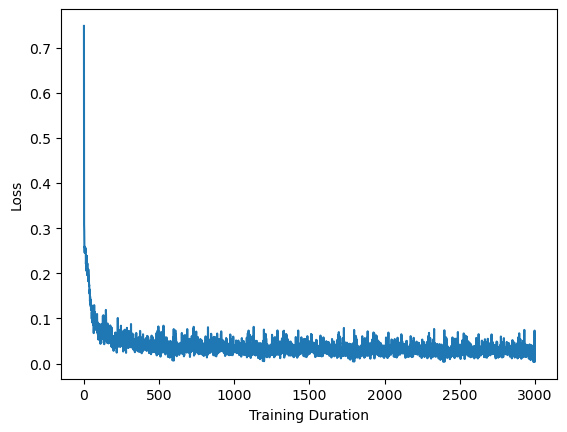

In [17]:
plt.plot(losses)
plt.xlabel("Training Duration") # Doesn't really make sense, but it is just for visualization purposes
plt.ylabel("Loss")
plt.show()

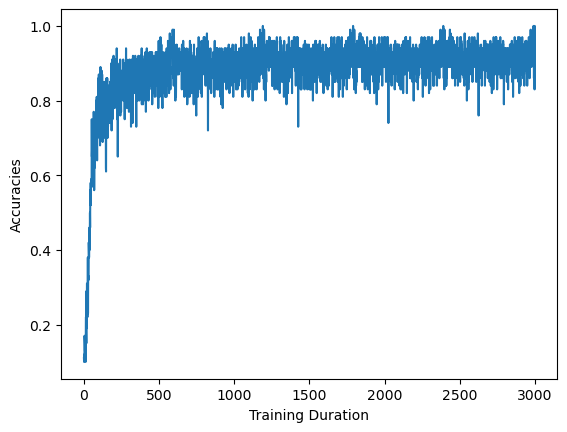

In [18]:
plt.plot(accuracies)
plt.xlabel("Training Duration") # Doesn't really make sense, but it is just for visualization purposes
plt.ylabel("Accuracies")
plt.show()

#### Testing

In [19]:
print("Accuracy on test set: ", evaluate(model, x_test, y_test))

Accuracy on test set:  0.9134


In [20]:
def test_loss(model, x_test, y_test):
    total_loss = 0
    for i in range(len(x_test)):
        output = forward(model, x_test[i])
        loss = cross_entropy_loss(y_test[i], output)
        total_loss += loss
    return total_loss / len(x_test)

print("Loss on test set: ", test_loss(model, x_test, y_test))

Loss on test set:  0.0300089251107386
